In [2]:
import numpy as np
import math
import gymnasium as gym
from gymnasium import spaces
import copy
from enum import Enum, auto

In [3]:
np.set_printoptions(precision=3, suppress=True)

In [4]:
np.random.seed(0)

In [50]:
class Function_Type(Enum):
    ROOT = auto()
    POW = auto()
    SUB = auto()
    ADD = auto()
    MUL = auto()
    DIV = auto()

    @property
    def inverse(self):
        """Simple inverse mapping."""
        return {
            Function_Type.POW: Function_Type.ROOT,
            Function_Type.SUB: Function_Type.ADD,
            Function_Type.MUL: Function_Type.DIV,
            Function_Type.DIV: Function_Type.MUL,
            Function_Type.ROOT: Function_Type.POW,
            Function_Type.ADD: Function_Type.SUB,
        }[self]

In [163]:
class func:
    def __init__(self, func_type: Function_Type, a: int, b: int, func_arg: int, sub_func = None, complexity: int = 0):
      self.a = a
      self.b = b
      self.func_arg = func_arg
      self.func = func_type
      self.sub_func = sub_func
      if sub_func:
        self.complexity = sub_func.complexity + 1
      else:
        self.complexity = 1

    def apply_function(self, func_applied: Function_Type, arg: float = None):
      """
      Apply a function transformation.
      For arithmetic ops (ADD, SUB, MUL, DIV): modify a and b, then check if we can unwrap
      For function ops (ROOT, POW): add a new layer or unwrap if it's the inverse
      """

      # Handle arithmetic operations
      if func_applied == Function_Type.SUB:
          self.a = float(self.a)
          self.b = float(self.b)
          self.b -= arg
          # After arithmetic op, check if we've reached a=1, b=0 and can unwrap
          if (np.isclose(self.a, 1.0, atol=1e-6) and
              np.isclose(self.b, 0.0, atol=1e-6) and
              self.sub_func is not None):
              # We've normalized! Return the inner function
              return self.sub_func
          return self

      elif func_applied == Function_Type.ADD:
          self.a = float(self.a)
          self.b = float(self.b)
          self.b += arg
          # Check if normalized
          if (np.isclose(self.a, 1.0, atol=1e-6) and
              np.isclose(self.b, 0.0, atol=1e-6) and
              self.sub_func is not None):
              return self.sub_func
          return self

      elif func_applied == Function_Type.MUL:
          self.a = float(self.a)
          self.b = float(self.b)
          self.a *= arg
          self.b *= arg
          # Check if normalized
          if (np.isclose(self.a, 1.0, atol=1e-6) and
              np.isclose(self.b, 0.0, atol=1e-6) and
              self.sub_func is not None):
              return self.sub_func
          return self

      elif func_applied == Function_Type.DIV:
          if arg == 0:
              return self
          self.a = float(self.a)
          self.b = float(self.b)
          self.a /= arg
          self.b /= arg
          # Check if normalized
          if (np.isclose(self.a, 1.0, atol=1e-6) and
              np.isclose(self.b, 0.0, atol=1e-6) and
              self.sub_func is not None):
              return self.sub_func
          return self

      # Handle function operations (ROOT, POW)
      elif func_applied == self.func.inverse and arg == self.func_arg:
          # Trying to apply inverse function
          if (np.isclose(float(self.a), 1.0, atol=1e-6) and
              np.isclose(float(self.b), 0.0, atol=1e-6)):
              # Successfully unwrap this layer
              return self.sub_func  # Can return None if no sub_func
          else:
              # Can't unwrap yet, add a new layer
              new_func = func(func_applied, 1, 0, func_arg=arg, sub_func=self)
              return new_func
      else:
          # Adding a new layer with different function
          new_func = func(func_applied, 1, 0, func_arg=arg, sub_func=self)
          return new_func

    def evaluate(self, x):
        if self.sub_func:
          inner_val = self.sub_func.evaluate(x)
        else:
          inner_val = x  # base variable

        if self.func == Function_Type.ROOT:
          val = np.sign(inner_val) * np.pow(np.abs(inner_val), 1/self.func_arg)
        elif self.func == Function_Type.POW:
          val = np.sign(inner_val) * np.pow(np.abs(inner_val), self.func_arg)

        val = self.a * val + self.b

        return val

    def __repr__(self):
      return f"{self.a} * {self.func}( {self.sub_func} )^{self.func_arg} + {self.b}"

In [164]:
def generate_samples(n=500, xmin=-10, xmax=10):
    """Generate n evenly spaced samples between xmin and xmax."""
    return np.linspace(xmin, xmax, n)

In [165]:
# Create a simple nested function: f(x) = 2 * SIN(3x + 1) - 4
inner = func(Function_Type.POW, 1, 2, func_arg = 1, complexity=1)  # 3x + 1
outer = func(Function_Type.POW, 1, 2, func_arg=3, sub_func = inner)
print(outer.complexity)
print(outer)
y = []
xs = generate_samples()
for x in xs:
  y.append(outer.evaluate(x))
print(xs[:5], y[:5])

2
1 * Function_Type.POW( 1 * Function_Type.POW( None )^1 + 2 )^3 + 2
[-10.    -9.96  -9.92  -9.88  -9.84] [np.float64(-510.0), np.float64(-502.34309889492755), np.float64(-494.7629196006723), np.float64(-487.25907580398695), np.float64(-479.83118119162486)]


In [166]:
xs = generate_samples()
gen_func = func(Function_Type.POW, 1, 2, 3, complexity=2)

In [167]:
gen_func = gen_func.apply_function(Function_Type.ROOT, arg = 3)

In [168]:
gen_func.evaluate(xs)

array([-9.993, -9.953, -9.913, -9.873, -9.833, -9.793, -9.753, -9.712,
       -9.672, -9.632, -9.592, -9.552, -9.512, -9.472, -9.431, -9.391,
       -9.351, -9.311, -9.271, -9.231, -9.191, -9.15 , -9.11 , -9.07 ,
       -9.03 , -8.99 , -8.95 , -8.909, -8.869, -8.829, -8.789, -8.749,
       -8.709, -8.668, -8.628, -8.588, -8.548, -8.508, -8.468, -8.427,
       -8.387, -8.347, -8.307, -8.267, -8.227, -8.186, -8.146, -8.106,
       -8.066, -8.026, -7.986, -7.945, -7.905, -7.865, -7.825, -7.785,
       -7.744, -7.704, -7.664, -7.624, -7.584, -7.543, -7.503, -7.463,
       -7.423, -7.383, -7.342, -7.302, -7.262, -7.222, -7.181, -7.141,
       -7.101, -7.061, -7.021, -6.98 , -6.94 , -6.9  , -6.86 , -6.819,
       -6.779, -6.739, -6.699, -6.658, -6.618, -6.578, -6.538, -6.497,
       -6.457, -6.417, -6.376, -6.336, -6.296, -6.256, -6.215, -6.175,
       -6.135, -6.094, -6.054, -6.014, -5.973, -5.933, -5.893, -5.852,
       -5.812, -5.772, -5.731, -5.691, -5.651, -5.61 , -5.57 , -5.529,
      

In [169]:
gen_func.evaluate(xs)

array([-9.993, -9.953, -9.913, -9.873, -9.833, -9.793, -9.753, -9.712,
       -9.672, -9.632, -9.592, -9.552, -9.512, -9.472, -9.431, -9.391,
       -9.351, -9.311, -9.271, -9.231, -9.191, -9.15 , -9.11 , -9.07 ,
       -9.03 , -8.99 , -8.95 , -8.909, -8.869, -8.829, -8.789, -8.749,
       -8.709, -8.668, -8.628, -8.588, -8.548, -8.508, -8.468, -8.427,
       -8.387, -8.347, -8.307, -8.267, -8.227, -8.186, -8.146, -8.106,
       -8.066, -8.026, -7.986, -7.945, -7.905, -7.865, -7.825, -7.785,
       -7.744, -7.704, -7.664, -7.624, -7.584, -7.543, -7.503, -7.463,
       -7.423, -7.383, -7.342, -7.302, -7.262, -7.222, -7.181, -7.141,
       -7.101, -7.061, -7.021, -6.98 , -6.94 , -6.9  , -6.86 , -6.819,
       -6.779, -6.739, -6.699, -6.658, -6.618, -6.578, -6.538, -6.497,
       -6.457, -6.417, -6.376, -6.336, -6.296, -6.256, -6.215, -6.175,
       -6.135, -6.094, -6.054, -6.014, -5.973, -5.933, -5.893, -5.852,
       -5.812, -5.772, -5.731, -5.691, -5.651, -5.61 , -5.57 , -5.529,
      

In [170]:
gen_func = gen_func.apply_function(Function_Type.SUB, 2)

In [171]:
gen_func = gen_func.apply_function(Function_Type.MUL, 1)

In [172]:
gen_func = gen_func.apply_function(Function_Type.ROOT, 3)

In [173]:
print(gen_func)

1 * Function_Type.ROOT( 1.0 * Function_Type.ROOT( 1 * Function_Type.POW( None )^3 + 2 )^3 + -2.0 )^3 + 0


In [178]:
class FunctionSimplificationEnv(gym.Env):
    """
    RL Environment for learning to simplify functions.

    Action Space:
        - Function type (6 options): ROOT, POW, SUB, ADD, MUL, DIV
        - Function argument for ROOT/POW: [1, 3, 5]
        - Argument for SUB/ADD/MUL/DIV: [1, 2, 3]

    Total actions: We'll use a discrete action space combining all possibilities
    - ROOT with arg [1,3,5]: 3 actions
    - POW with arg [1,3,5]: 3 actions
    - SUB with arg [1,2,3]: 3 actions
    - ADD with arg [1,2,3]: 3 actions
    - MUL with arg [1,2,3]: 3 actions
    - DIV with arg [1,2,3]: 3 actions
    Total: 18 actions

    Observation Space:
        - Current y-values from evaluating the function (500 samples)
        - Target y-values (x values, representing simplified function)
        - Steps remaining
        - Current complexity
    """

    def __init__(self, max_steps=6, max_complexity=3, n_samples=500):
        super(FunctionSimplificationEnv, self).__init__()

        self.max_steps = max_steps
        self.max_complexity = max_complexity
        self.n_samples = n_samples
        self.xs = generate_samples(n=n_samples)

        # Define action space
        # 18 discrete actions as described above
        self.action_space = spaces.Discrete(14)

        # Define observation space
        # Current function outputs + target outputs + metadata
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(n_samples * 2 + 16,),
            dtype=np.float32
        )
        # Action mapping
        self.action_map = self._create_action_map()

        self.reset()

    def _create_action_map(self):
      """Create mapping from action index to (function_type, argument)."""
      actions = []

      # ROOT with args [3, 5] only (exclude 1 as it does nothing)
      for arg in [3, 5]:
          actions.append((Function_Type.ROOT, arg))

      # POW with args [3, 5] only (exclude 1 as it does nothing)
      for arg in [3, 5]:
          actions.append((Function_Type.POW, arg))

      # SUB with args [1, 2, 3]
      for arg in [1, 2, 3]:
          actions.append((Function_Type.SUB, arg))

      # ADD with args [1, 2, 3]
      for arg in [1, 2, 3]:
          actions.append((Function_Type.ADD, arg))

      # MUL with args [2, 3] only (exclude 1 as it does nothing)
      for arg in [2, 3]:
          actions.append((Function_Type.MUL, arg))

      # DIV with args [2, 3] only (exclude 1 as it does nothing)
      for arg in [2, 3]:
          actions.append((Function_Type.DIV, arg))

      return actions

    def _generate_random_function(self):
        """Generate a random function with complexity between 1 and max_complexity."""
        complexity = 1 #np.random.randint(1, self.max_complexity + 1)

        # Start with identity: f(x) = x
        current_func = None

        for _ in range(complexity):
            # Choose random function type (only ROOT and POW for composability)
            func_type = np.random.choice([Function_Type.ROOT, Function_Type.POW])
            func_arg = np.random.choice([1, 3, 5])
            a = np.random.choice([1, 2, 3])
            b = np.random.choice([0, 1, 2, 3])  # Allow 0 for b

            current_func = func(func_type, a, b, func_arg, sub_func=current_func)

        return current_func

    def _compute_function_features(self, y_vals, x_vals):
      """
      Compute features that indicate the shape of the function.
      These help the model identify if ROOT or POW operations are needed.
      """
      features = {}

      # Avoid division by zero and infinities
      safe_x = x_vals.copy()
      safe_x[np.abs(safe_x) < 1e-8] = 1e-8
      safe_y = y_vals.copy()

      # 1. Log-log slope (indicates power relationship)
      # If y = x^n, then log(y) = n*log(x), slope of log-log plot = n
      positive_mask = (safe_x > 0) & (safe_y > 0)
      if np.sum(positive_mask) > 10:
          log_x = np.log(np.abs(safe_x[positive_mask]))
          log_y = np.log(np.abs(safe_y[positive_mask]))

          # Linear regression on log-log plot
          if len(log_x) > 1:
              slope, _ = np.polyfit(log_x, log_y, 1)
              features['log_log_slope'] = slope
          else:
              features['log_log_slope'] = 1.0
      else:
          features['log_log_slope'] = 1.0

      # 2. Second derivative (curvature)
      # Positive curvature suggests convex (like x^2)
      # Negative curvature suggests concave (like sqrt(x))
      if len(y_vals) > 2:
          first_deriv = np.gradient(y_vals, x_vals)
          second_deriv = np.gradient(first_deriv, x_vals)
          features['mean_curvature'] = np.mean(second_deriv[np.isfinite(second_deriv)])
          features['curvature_std'] = np.std(second_deriv[np.isfinite(second_deriv)])
      else:
          features['mean_curvature'] = 0.0
          features['curvature_std'] = 0.0

      # 3. Growth rate (how fast y changes relative to x)
      # High growth rate suggests power > 1, low suggests root
      if len(y_vals) > 1:
          growth_rate = np.abs(np.gradient(y_vals, x_vals))
          features['mean_growth_rate'] = np.mean(growth_rate[np.isfinite(growth_rate)])
      else:
          features['mean_growth_rate'] = 1.0

      # Handle NaN/inf
      for key in features:
          if not np.isfinite(features[key]):
              features[key] = 0.0

      return features

    def _get_observation(self):
      """Get current observation with enhanced features."""
      if self.current_func is None:
          current_y = self.xs
          current_complexity = 0
          func_type_encoding = np.zeros(6)
          func_arg = 1
          a_val = 1
          b_val = 0
          has_sub_func = 0
      else:
          current_y = self.current_func.evaluate(self.xs)
          current_complexity = self.current_func.complexity

          # One-hot encode the function type
          func_type_encoding = np.zeros(6)
          func_type_map = {
              Function_Type.ROOT: 0,
              Function_Type.POW: 1,
              Function_Type.SUB: 2,
              Function_Type.ADD: 3,
              Function_Type.MUL: 4,
              Function_Type.DIV: 5
          }
          func_type_encoding[func_type_map[self.current_func.func]] = 1

          func_arg = self.current_func.func_arg
          a_val = float(self.current_func.a)
          b_val = float(self.current_func.b)
          has_sub_func = 1 if self.current_func.sub_func is not None else 0

      target_y = self.xs

      # Compute function shape features
      shape_features = self._compute_function_features(current_y, self.xs)

      obs = np.concatenate([
          current_y,
          target_y,
          [self.steps_remaining / self.max_steps],
          [current_complexity / max(self.max_complexity, 1)],
          func_type_encoding,
          [func_arg / 5.0],  # Normalize
          [a_val / 3.0],  # Normalize
          [b_val / 3.0],  # Normalize
          [has_sub_func],
          [np.clip(shape_features['log_log_slope'] / 5.0, -2, 2)],  # Key feature!
          [np.clip(shape_features['mean_curvature'] / 10.0, -2, 2)],
          [np.clip(shape_features['curvature_std'] / 10.0, 0, 2)],
          [np.clip(shape_features['mean_growth_rate'] / 10.0, 0, 2)]
      ]).astype(np.float32)

      return obs

    def _compute_reward(self, prev_complexity, new_complexity, is_simplified):
        """Compute reward based on progress."""
        reward = 0

        # Large reward for complete simplification
        if is_simplified:
            reward += 100
            # Bonus for doing it quickly
            reward += self.steps_remaining * 10

        # Reward for reducing complexity
        elif new_complexity < prev_complexity:
            reward += 10 * (prev_complexity - new_complexity)

        # Small penalty for increasing complexity
        elif new_complexity > prev_complexity:
            reward -= 5 * (new_complexity - prev_complexity)

        # Small penalty for wasting a step
        else:
            reward -= 1

        return reward

    def _is_simplified(self):
      """Check if function is fully simplified (f(x) = x)."""
      try:
          # Need to check if current_func is None first
          if self.current_func is None:
              return True

          # A simplified function should be: f(x) = x
          # This means no sub_func, a=1, b=0, and func_arg=1
          if self.current_func.sub_func is None:
              # Check if it evaluates to identity
              test_vals = self.current_func.evaluate(self.xs)
              if np.allclose(test_vals, self.xs, rtol=1e-3, atol=1e-3):
                  return True
          return False
      except Exception as e:
          print(f"Error in _is_simplified: {e}")
          return False

    def reset(self, seed=None, options=None):
        """Reset the environment."""
        if seed is not None:
            np.random.seed(seed)

        self.target_func = self._generate_random_function()
        self.current_func = copy.deepcopy(self.target_func)
        self.steps_remaining = self.max_steps
        self.initial_complexity = self.current_func.complexity

        return self._get_observation(), {}

    def step(self, action):
        """Execute one step."""
        prev_complexity = self.current_func.complexity if self.current_func else 0

        # Decode action
        func_type, arg = self.action_map[action]

        # Apply function
        try:
            result = self.current_func.apply_function(func_type, arg)
            if result is not None:
                self.current_func = result
            # If result is None, current_func stays the same (arithmetic operations)
        except Exception as e:
            print(f"Error applying function: {e}")
            # Don't change current_func if there's an error

        self.steps_remaining -= 1

        # Check if simplified
        is_simplified = self._is_simplified()
        new_complexity = self.current_func.complexity if self.current_func else 0

        # Compute reward
        reward = self._compute_reward(prev_complexity, new_complexity, is_simplified)

        # Check termination
        terminated = is_simplified or self.steps_remaining <= 0
        truncated = False

        obs = self._get_observation()
        info = {
            'complexity': new_complexity,
            'initial_complexity': self.initial_complexity,
            'is_simplified': is_simplified,
            'steps_used': self.max_steps - self.steps_remaining
        }

        return obs, reward, terminated, truncated, info

Training with random actions...
Completed 100/10000 episodes


/tmp/ipython-input-918387341.py:204: RuntimeWarning: overflow encountered in cast
  ]).astype(np.float32)
/tmp/ipython-input-210990150.py:95: RuntimeWarning: overflow encountered in power
  val = np.sign(inner_val) * np.pow(np.abs(inner_val), self.func_arg)


Completed 200/10000 episodes
Completed 300/10000 episodes
Completed 400/10000 episodes
Completed 500/10000 episodes
Completed 600/10000 episodes
Completed 700/10000 episodes
Completed 800/10000 episodes
Completed 900/10000 episodes
Completed 1000/10000 episodes
Completed 1100/10000 episodes
Completed 1200/10000 episodes
Completed 1300/10000 episodes
Completed 1400/10000 episodes
Completed 1500/10000 episodes
Completed 1600/10000 episodes
Completed 1700/10000 episodes
Completed 1800/10000 episodes
Completed 1900/10000 episodes
Completed 2000/10000 episodes


/tmp/ipython-input-210990150.py:97: RuntimeWarning: overflow encountered in multiply
  val = self.a * val + self.b


Completed 2100/10000 episodes
Completed 2200/10000 episodes
Completed 2300/10000 episodes
Completed 2400/10000 episodes
Completed 2500/10000 episodes
Completed 2600/10000 episodes
Completed 2700/10000 episodes
Completed 2800/10000 episodes
Completed 2900/10000 episodes
Completed 3000/10000 episodes
Completed 3100/10000 episodes
Completed 3200/10000 episodes
Completed 3300/10000 episodes
Completed 3400/10000 episodes
Completed 3500/10000 episodes
Completed 3600/10000 episodes
Completed 3700/10000 episodes
Completed 3800/10000 episodes
Completed 3900/10000 episodes
Completed 4000/10000 episodes
Completed 4100/10000 episodes
Completed 4200/10000 episodes
Completed 4300/10000 episodes
Completed 4400/10000 episodes
Completed 4500/10000 episodes
Completed 4600/10000 episodes
Completed 4700/10000 episodes
Completed 4800/10000 episodes
Completed 4900/10000 episodes
Completed 5000/10000 episodes
Completed 5100/10000 episodes
Completed 5200/10000 episodes
Completed 5300/10000 episodes
Completed 

/tmp/ipython-input-2698820615.py:204: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


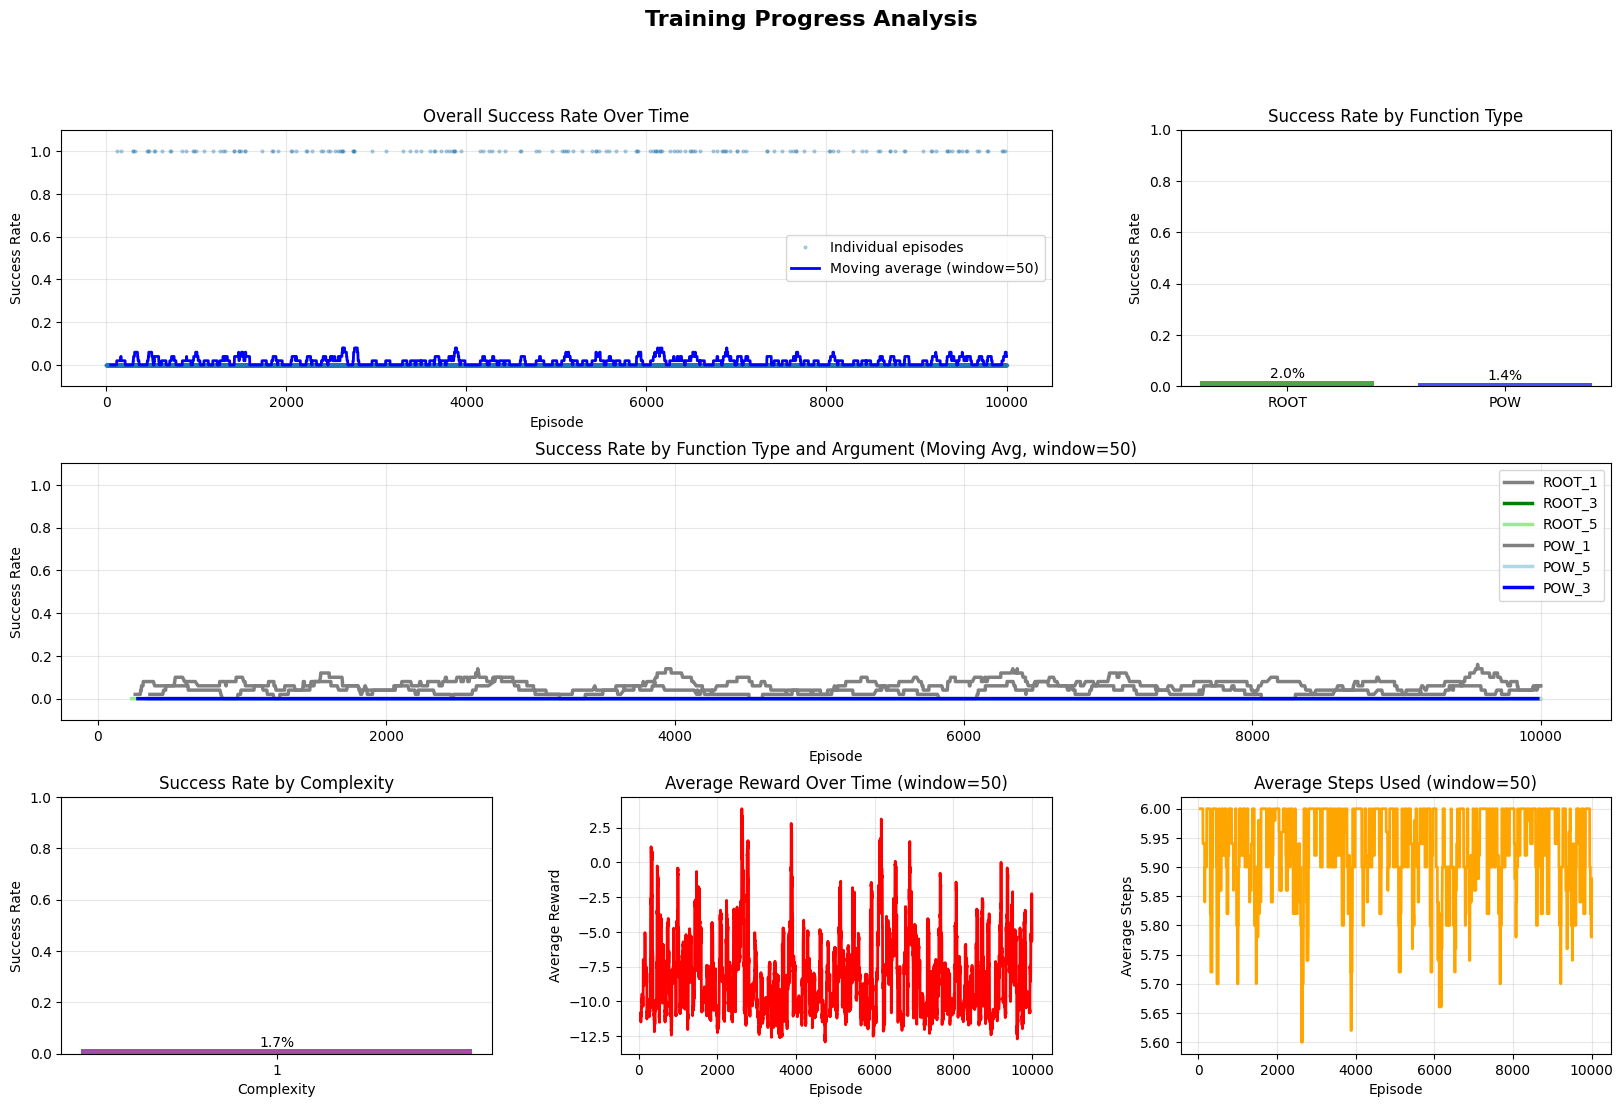


Visualizing last 3 episodes...


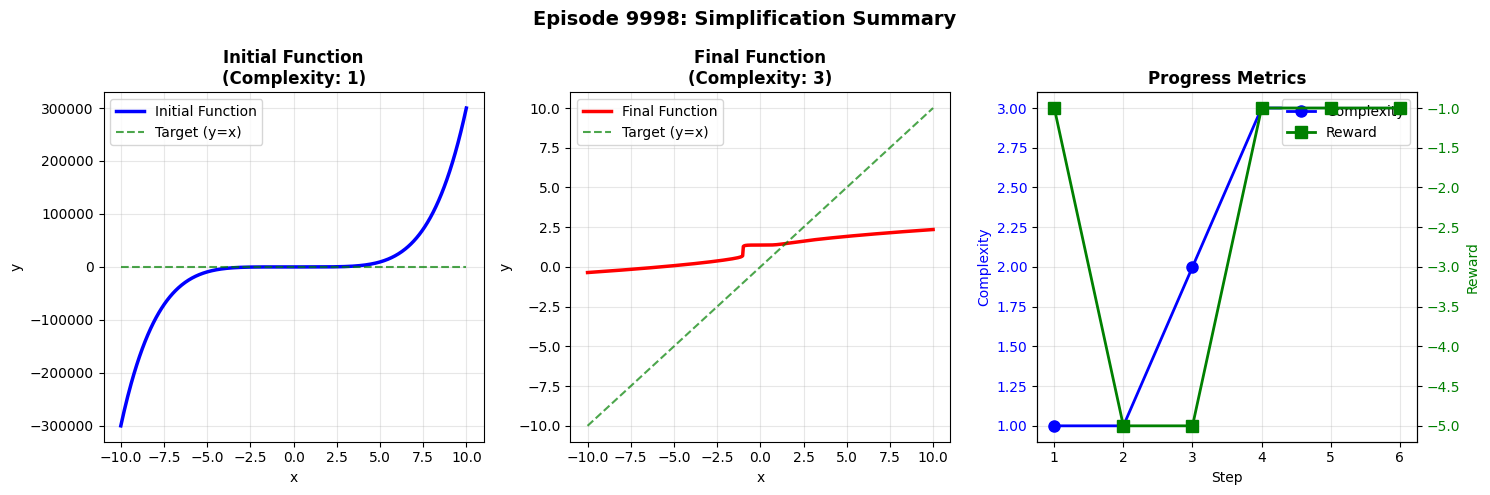

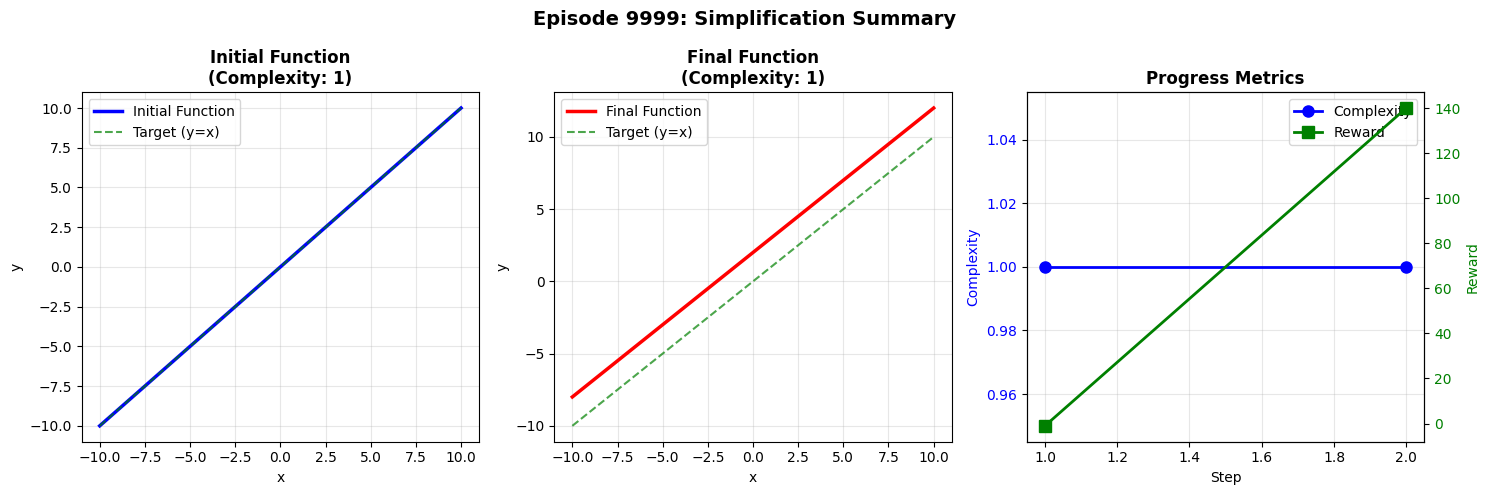

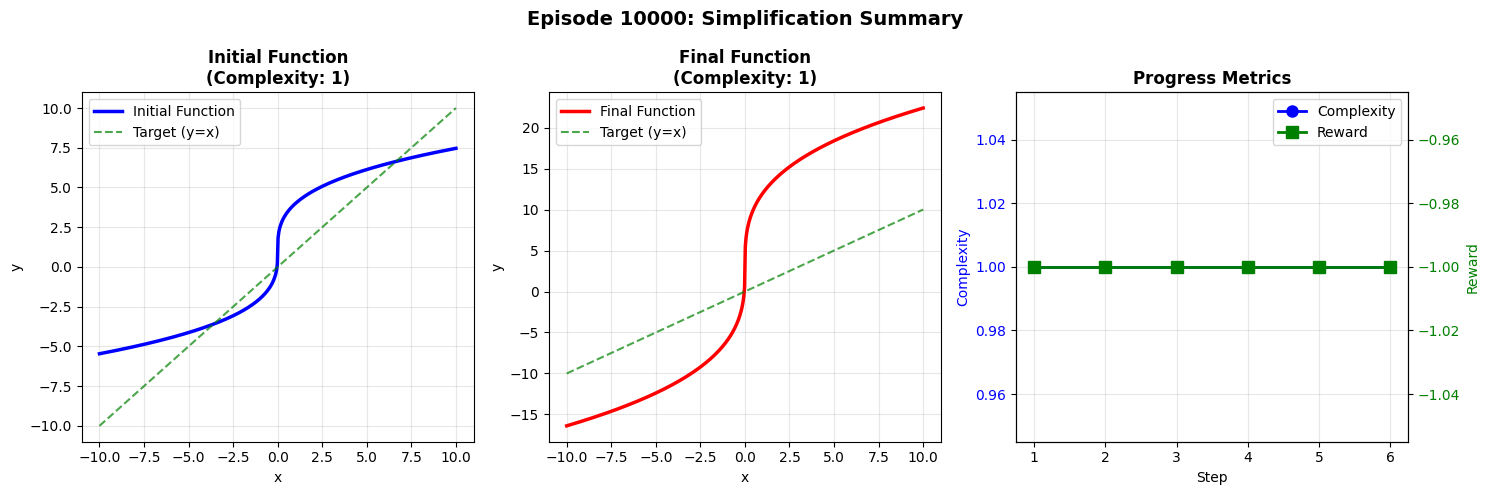

In [182]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from collections import defaultdict
import numpy as np

class TrainingMonitor:
    """
    Monitor and visualize training progress across episodes.
    Tracks success rates for different function types and complexities.
    """

    def __init__(self):
        self.episode_data = []
        self.success_by_func_type = defaultdict(lambda: {'attempts': 0, 'successes': 0})
        self.success_by_func_arg = defaultdict(lambda: {'attempts': 0, 'successes': 0})
        self.success_by_complexity = defaultdict(lambda: {'attempts': 0, 'successes': 0})
        self.rewards_history = []
        self.steps_history = []

    def record_episode(self, env, episode_history, episode_num, success):
        """
        Record episode results for later analysis.

        Args:
            env: Environment instance
            episode_history: List of step dictionaries
            episode_num: Episode number
            success: Whether the episode was successful
        """
        initial_func = episode_history[0]['function'] if episode_history else env.target_func

        # Record basic episode info
        episode_info = {
            'episode': episode_num,
            'success': success,
            'initial_complexity': initial_func.complexity,
            'func_type': initial_func.func.name,
            'func_arg': initial_func.func_arg,
            'total_reward': sum(step['reward'] for step in episode_history),
            'steps_used': len(episode_history)
        }

        self.episode_data.append(episode_info)

        # Track success rates by function type
        key = f"{initial_func.func.name}"
        self.success_by_func_type[key]['attempts'] += 1
        if success:
            self.success_by_func_type[key]['successes'] += 1

        # Track success rates by function argument (for ROOT/POW)
        if initial_func.func in [Function_Type.ROOT, Function_Type.POW]:
            key = f"{initial_func.func.name}_{initial_func.func_arg}"
            self.success_by_func_arg[key]['attempts'] += 1
            if success:
                self.success_by_func_arg[key]['successes'] += 1

        # Track success rates by complexity
        key = f"complexity_{initial_func.complexity}"
        self.success_by_complexity[key]['attempts'] += 1
        if success:
            self.success_by_complexity[key]['successes'] += 1

        # Store rewards and steps
        self.rewards_history.append(episode_info['total_reward'])
        self.steps_history.append(episode_info['steps_used'])

    def plot_training_progress(self, window_size=100):
        """
        Create comprehensive visualization of training progress.

        Args:
            window_size: Size of moving average window for smoothing
        """
        if len(self.episode_data) < 10:
            print("Not enough episodes to plot (need at least 10)")
            return

        fig = plt.figure(figsize=(20, 12))
        gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)

        fig.suptitle('Training Progress Analysis', fontsize=16, fontweight='bold')

        # 1. Success rate over time (moving average)
        ax1 = fig.add_subplot(gs[0, :2])
        episodes = [d['episode'] for d in self.episode_data]
        successes = [1 if d['success'] else 0 for d in self.episode_data]

        # Compute moving average
        moving_avg = self._moving_average(successes, window_size)

        ax1.plot(episodes, successes, 'o', alpha=0.3, markersize=2, label='Individual episodes')
        ax1.plot(episodes[window_size-1:], moving_avg, 'b-', linewidth=2,
                label=f'Moving average (window={window_size})')
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Success Rate')
        ax1.set_title('Overall Success Rate Over Time')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim([-0.1, 1.1])

        # 2. Success rate by function type (ROOT vs POW)
        ax2 = fig.add_subplot(gs[0, 2])
        func_types = []
        success_rates = []

        for func_type in ['ROOT', 'POW']:
            if func_type in self.success_by_func_type:
                data = self.success_by_func_type[func_type]
                if data['attempts'] > 0:
                    func_types.append(func_type)
                    success_rates.append(data['successes'] / data['attempts'])

        if func_types:
            bars = ax2.bar(func_types, success_rates, color=['green', 'blue'], alpha=0.7)
            ax2.set_ylabel('Success Rate')
            ax2.set_title('Success Rate by Function Type')
            ax2.set_ylim([0, 1])
            ax2.grid(True, alpha=0.3, axis='y')

            # Add percentage labels on bars
            for bar, rate in zip(bars, success_rates):
                height = bar.get_height()
                ax2.text(bar.get_x() + bar.get_width()/2., height,
                        f'{rate*100:.1f}%', ha='center', va='bottom')

        # 3. Success rate by function argument over time (KEY PLOT)
        ax3 = fig.add_subplot(gs[1, :])

        # Separate episodes by func_arg
        func_args = {}
        for episode_data in self.episode_data:
            func_type = episode_data['func_type']
            if func_type in ['ROOT', 'POW']:
                key = f"{func_type}_{episode_data['func_arg']}"
                if key not in func_args:
                    func_args[key] = {'episodes': [], 'successes': []}
                func_args[key]['episodes'].append(episode_data['episode'])
                func_args[key]['successes'].append(1 if episode_data['success'] else 0)

        colors = {'ROOT_3': 'green', 'ROOT_5': 'lightgreen',
                 'POW_3': 'blue', 'POW_5': 'lightblue'}

        for key, data in func_args.items():
            if len(data['episodes']) > window_size:
                moving_avg = self._moving_average(data['successes'], window_size)
                episodes_plot = data['episodes'][window_size-1:]
                ax3.plot(episodes_plot, moving_avg, '-', linewidth=2.5,
                        label=key, color=colors.get(key, 'gray'))

        ax3.set_xlabel('Episode')
        ax3.set_ylabel('Success Rate')
        ax3.set_title(f'Success Rate by Function Type and Argument (Moving Avg, window={window_size})')
        ax3.legend(loc='best')
        ax3.grid(True, alpha=0.3)
        ax3.set_ylim([-0.1, 1.1])

        # 4. Success rate by complexity
        ax4 = fig.add_subplot(gs[2, 0])
        complexities = []
        complexity_rates = []

        for key in sorted(self.success_by_complexity.keys()):
            data = self.success_by_complexity[key]
            if data['attempts'] > 0:
                complexity_num = int(key.split('_')[1])
                complexities.append(complexity_num)
                complexity_rates.append(data['successes'] / data['attempts'])

        if complexities:
            bars = ax4.bar([str(c) for c in complexities], complexity_rates,
                          color='purple', alpha=0.7)
            ax4.set_xlabel('Complexity')
            ax4.set_ylabel('Success Rate')
            ax4.set_title('Success Rate by Complexity')
            ax4.set_ylim([0, 1])
            ax4.grid(True, alpha=0.3, axis='y')

            for bar, rate in zip(bars, complexity_rates):
                height = bar.get_height()
                ax4.text(bar.get_x() + bar.get_width()/2., height,
                        f'{rate*100:.1f}%', ha='center', va='bottom')

        # 5. Average reward over time
        ax5 = fig.add_subplot(gs[2, 1])
        if len(self.rewards_history) > window_size:
            reward_moving_avg = self._moving_average(self.rewards_history, window_size)
            ax5.plot(episodes[window_size-1:], reward_moving_avg, 'r-', linewidth=2)
            ax5.set_xlabel('Episode')
            ax5.set_ylabel('Average Reward')
            ax5.set_title(f'Average Reward Over Time (window={window_size})')
            ax5.grid(True, alpha=0.3)

        # 6. Average steps used over time
        ax6 = fig.add_subplot(gs[2, 2])
        if len(self.steps_history) > window_size:
            steps_moving_avg = self._moving_average(self.steps_history, window_size)
            ax6.plot(episodes[window_size-1:], steps_moving_avg, 'orange', linewidth=2)
            ax6.set_xlabel('Episode')
            ax6.set_ylabel('Average Steps')
            ax6.set_title(f'Average Steps Used (window={window_size})')
            ax6.grid(True, alpha=0.3)

        plt.tight_layout()
        return fig

    def _moving_average(self, data, window_size):
        """Compute moving average."""
        if len(data) < window_size:
            window_size = len(data)
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

    def print_summary_statistics(self):
        """Print summary statistics of training."""
        print("\n" + "="*60)
        print("TRAINING SUMMARY STATISTICS")
        print("="*60)

        total_episodes = len(self.episode_data)
        total_successes = sum(1 for d in self.episode_data if d['success'])

        print(f"\nTotal Episodes: {total_episodes}")
        print(f"Total Successes: {total_successes}")
        print(f"Overall Success Rate: {total_successes/total_episodes*100:.2f}%")

        print("\n--- Success Rate by Function Type ---")
        for func_type, data in sorted(self.success_by_func_type.items()):
            if data['attempts'] > 0:
                rate = data['successes'] / data['attempts']
                print(f"{func_type:15s}: {rate*100:6.2f}% ({data['successes']}/{data['attempts']})")

        print("\n--- Success Rate by Function Argument ---")
        for key, data in sorted(self.success_by_func_arg.items()):
            if data['attempts'] > 0:
                rate = data['successes'] / data['attempts']
                print(f"{key:15s}: {rate*100:6.2f}% ({data['successes']}/{data['attempts']})")

        print("\n--- Success Rate by Complexity ---")
        for key, data in sorted(self.success_by_complexity.items()):
            if data['attempts'] > 0:
                rate = data['successes'] / data['attempts']
                print(f"{key:15s}: {rate*100:6.2f}% ({data['successes']}/{data['attempts']})")

        if self.rewards_history:
            print(f"\n--- Reward Statistics ---")
            print(f"Average Reward: {np.mean(self.rewards_history):.2f}")
            print(f"Max Reward: {np.max(self.rewards_history):.2f}")
            print(f"Min Reward: {np.min(self.rewards_history):.2f}")

        if self.steps_history:
            print(f"\n--- Steps Statistics ---")
            print(f"Average Steps: {np.mean(self.steps_history):.2f}")
            print(f"Max Steps: {np.max(self.steps_history):.0f}")
            print(f"Min Steps: {np.min(self.steps_history):.0f}")

        print("="*60 + "\n")


# Modified example usage with monitoring
if __name__ == "__main__":
    env = FunctionSimplificationEnv()
    monitor = TrainingMonitor()

    print("Training with random actions...")
    num_episodes = 10000

    for episode in range(num_episodes):
        obs, info = env.reset()

        episode_history = []
        done = False

        while not done:
            action = env.action_space.sample()
            func_type, arg = env.action_map[action]

            # Store pre-step information
            step_info = {
                'function': copy.deepcopy(env.current_func),
                'action_type': func_type,
                'action_arg': arg,
                'complexity': env.current_func.complexity if env.current_func else 0
            }

            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            # Update step info with results
            step_info['reward'] = reward
            step_info['is_simplified'] = info['is_simplified']
            episode_history.append(step_info)

        # Record episode results
        success = info['is_simplified']
        monitor.record_episode(env, episode_history, episode + 1, success)

        # Print progress every 100 episodes
        if (episode + 1) % 100 == 0:
            print(f"Completed {episode + 1}/{num_episodes} episodes")

    # Print summary statistics
    monitor.print_summary_statistics()

    # Plot training progress
    fig = monitor.plot_training_progress(window_size=50)
    plt.show()

    # Optionally visualize last few episodes
    print("\nVisualizing last 3 episodes...")
    for episode in range(max(0, num_episodes - 3), num_episodes):
        # Re-run last episodes for visualization (in practice, you'd save episode_history)
        obs, info = env.reset(seed=episode)
        episode_history = []
        done = False

        while not done:
            action = env.action_space.sample()
            func_type, arg = env.action_map[action]

            step_info = {
                'function': copy.deepcopy(env.current_func),
                'action_type': func_type,
                'action_arg': arg,
                'complexity': env.current_func.complexity if env.current_func else 0
            }

            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            step_info['reward'] = reward
            step_info['is_simplified'] = info['is_simplified']
            episode_history.append(step_info)

        # Use your existing visualization functions
        fig1 = visualize_comparison(env, episode_history, episode + 1)

    plt.show()